# Neural Network Fundamentals 

**Session Topic:** The Perceptron Model, Multi-Layer Perceptrons (MLP), and Backpropagation Intuition.

**Target Audience:** Professors and Instructors.

**Objective:** 
1. Understand the mathematical foundation of a single neuron (Perceptron).
2. Visualize decision boundaries using synthetic datasets (`make_blobs`, `make_moons`).
3. Gain intuition on how networks learn (Backpropagation).
4. Implement an MLP to solve non-linear problems.
5. Understand the role of Hardware (CPU vs GPU) in acceleration.

## 1. Environment Setup
We will primarily use `numpy` for linear algebra operations, `matplotlib` for visualization, and `sklearn` for generating synthetic datasets.

In [6]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.datasets import make_moons, make_blobs
import time

# Ensure plots display inline in the notebook
%matplotlib inline

print("Libraries imported successfully.")
print(f"NumPy Version: {np.__version__}")

Libraries imported successfully.
NumPy Version: 2.1.3


## 2. The Perceptron Model (From Scratch)

The Perceptron is the fundamental building block of neural networks. It is a binary classifier that maps input $x$ to an output $f(x)$.

### Mathematical Definition
$$z = \sum_{i=1}^{n} w_i x_i + b = \mathbf{w} \cdot \mathbf{x} + b$$
$$\hat{y} = \begin{cases} 1 & \text{if } z \geq 0 \\ 0 & \text{if } z < 0 \end{cases}$$

Where:
- $\mathbf{w}$: Weights vector
- $\mathbf{x}$: Input vector
- $b$: Bias (shifting the activation threshold)
- $z$: Net input (weighted sum)
- $\hat{y}$: Prediction (using a Step Function activation)

In [7]:
class Perceptron:
    """
    A simple implementation of the Perceptron learning algorithm with sigmoid activation.
    """
    def __init__(self, learning_rate=0.1, epochs=10):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Train the perceptron weights on dataset X and labels y using sigmoid activation.
        """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self._sigmoid(linear_output)
                # For binary cross-entropy, typical update would use error as (y - y_predicted)
                update = self.lr * (y[idx] - y_predicted)
                self.weights += update * x_i
                self.bias += update

    def predict(self, X):
        """Predict class labels for samples in X using a sigmoid threshold at 0.5."""
        linear_output = np.dot(X, self.weights) + self.bias
        probs = self._sigmoid(linear_output)
        return (probs >= 0.5).astype(int)

    def _sigmoid(self, x):
        """Numerically stable sigmoid."""
        return 1 / (1 + np.exp(-x))

### Visualizing the Decision Boundary
We define a helper function to plot the decision boundary. We can now specify axis labels (with units) to make the examples more concrete.

In [8]:
def plot_decision_boundary(X, y, classifier, title="Decision Boundary", xlabel="Feature 1", ylabel="Feature 2"):
    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

### Example 1: Linearly Separable Data (`make_blobs`)

We use `make_blobs` to generate distinct clusters of data. This represents a simple, linearly separable problem.

**Real World Analogy:**
Imagine we are classifying fruits based on two features:
1. **Weight (in grams)**
2. **Color Intensity (scale 1-10)**

Class 0 might be **Apples** (Heavier, Redder) and Class 1 might be **Limes** (Lighter, Greener). A single straight line can easily separate these two groups.

Training complete on Blobs dataset.


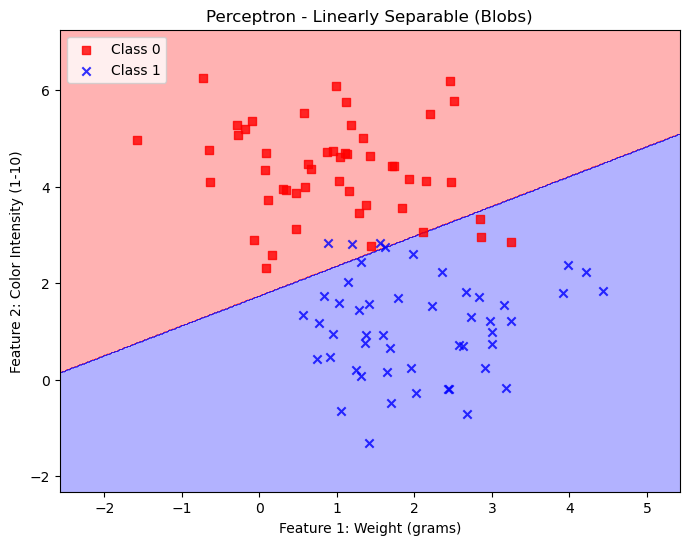

In [9]:
# Generate Linearly Separable Data (Blobs)
X_blobs, y_blobs = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.0)

# Create and train perceptron
p_blobs = Perceptron(learning_rate=0.1, epochs=10)
p_blobs.fit(X_blobs, y_blobs)

print("Training complete on Blobs dataset.")

# Visualize with Units
plot_decision_boundary(X_blobs, y_blobs, p_blobs, 
                      title="Perceptron - Linearly Separable (Blobs)",
                      xlabel="Feature 1: Weight (grams)",
                      ylabel="Feature 2: Color Intensity (1-10)")

## 3. The Limitation: Non-Linear Data (`make_moons`)

Real-world data is often complex and overlapping. We use `make_moons` to generate two interleaving half-circles.

**Real World Analogy:**
Consider a **Drug Dosage** problem:
- **Feature 1:** Dosage of Drug A
- **Feature 2:** Dosage of Drug B

If you take a *low* dose of both, you are fine (Healthy). If you take a *high* dose of both, you are fine (Healthy). But if you take a *high* dose of A and *low* dose of B (or vice versa), they interact toxically (Sick).

**Problem:** A straight line (Perceptron) cannot separate this "XOR-like" pattern.

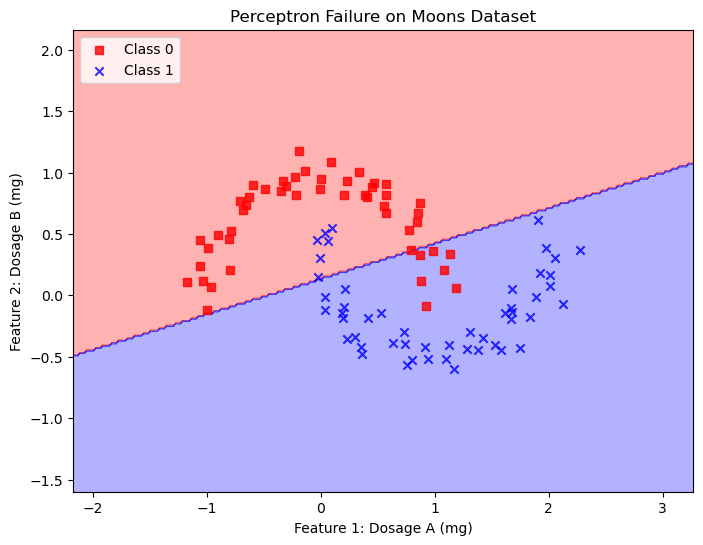

Notice how the linear boundary cannot correctly classify the curved shapes.


In [16]:
# Generate Non-Linear Data (Moons)
X_moons, y_moons = make_moons(n_samples=100, noise=0.1, random_state=42)

# Train Perceptron on Moons
p_moons = Perceptron(learning_rate=0.1, n_iterations=20)
p_moons.fit(X_moons, y_moons)

# Visualize failure
plot_decision_boundary(X_moons, y_moons, p_moons, 
                      title="Perceptron Failure on Moons Dataset",
                      xlabel="Feature 1: Dosage A (mg)",
                      ylabel="Feature 2: Dosage B (mg)")

print("Notice how the linear boundary cannot correctly classify the curved shapes.")

## 4. Backpropagation Intuition

To solve the "Moons" problem, we need a **Multi-Layer Perceptron (MLP)**. But how do we train multiple layers? We use **Backpropagation**.

### The Concept
1. **Forward Pass:** Input data flows through the network layers to produce a prediction.
2. **Loss Calculation:** We compare prediction vs actual ($Loss = (y - \hat{y})^2$).
3. **Backward Pass (Chain Rule):** We calculate the gradient of the Loss with respect to every weight in the network.

$$\frac{\partial Loss}{\partial w} = \frac{\partial Loss}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} \cdot \frac{\partial z}{\partial w}$$

4. **Update:** Adjust weights in the opposite direction of the gradient to minimize error.

In [7]:
# INTUITION ONLY: Toy example of a single weight update

def simple_gradient_descent_step():
    # Imagine a simplified scenario:
    # Target y = 1.0
    # Current weight w = 0.5
    # Input x = 2.0
    # Prediction y_hat = w * x = 1.0
    
    x = 2.0
    y_target = 1.0
    w = 0.1 # Starting wrong
    learning_rate = 0.01
    
    print(f"Initial Weight: {w}")
    
    for i in range(5):
        # 1. Forward
        y_hat = w * x
        
        # 2. Loss (Squared Error): L = (y - y_hat)^2
        loss = (y_target - y_hat)**2
        
        # 3. Backward (Gradient Calculation)
        # dL/dw = dL/dy_hat * dy_hat/dw
        # dL/dy_hat = -2(y - y_hat)
        # dy_hat/dw = x
        gradient = -2 * (y_target - y_hat) * x
        
        # 4. Update
        w = w - learning_rate * gradient
        
        print(f"Iter {i+1}: Pred={y_hat:.2f}, Loss={loss:.4f}, Grad={gradient:.4f}, New Weight={w:.4f}")

simple_gradient_descent_step()

Initial Weight: 0.1
Iter 1: Pred=0.20, Loss=0.6400, Grad=-3.2000, New Weight=0.1320
Iter 2: Pred=0.26, Loss=0.5417, Grad=-2.9440, New Weight=0.1614
Iter 3: Pred=0.32, Loss=0.4585, Grad=-2.7085, New Weight=0.1885
Iter 4: Pred=0.38, Loss=0.3881, Grad=-2.4918, New Weight=0.2134
Iter 5: Pred=0.43, Loss=0.3285, Grad=-2.2925, New Weight=0.2364


## 5. Multi-Layer Perceptron (MLP)

We introduce:
1. **Hidden Layers:** Allow the network to learn intermediate representations.
2. **Non-Linear Activation Functions:** (e.g., Sigmoid, ReLU) allow the network to draw curved decision boundaries.

We will use `sklearn.neural_network.MLPClassifier` to solve the "Moons" problem.

Training Score: 1.0


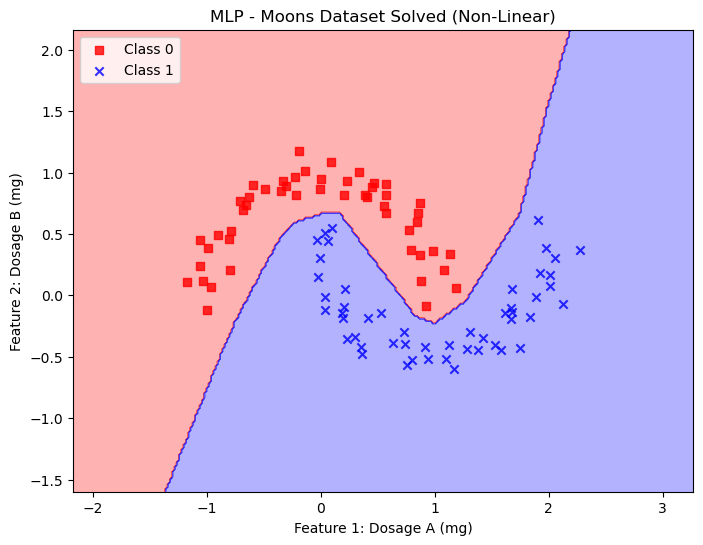

In [8]:
from sklearn.neural_network import MLPClassifier

# Setup MLP
# hidden_layer_sizes=(10, 10): Two hidden layers with 10 neurons each for complex curves
# activation='relu': Rectified Linear Unit (adds non-linearity)
# max_iter=10000: Allow enough time to converge
mlp = MLPClassifier(hidden_layer_sizes=(10, 10),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.01,
                    random_state=42,
                    max_iter=2000)

# Train on Moons data
mlp.fit(X_moons, y_moons)

print("Training Score:", mlp.score(X_moons, y_moons))

# Visualize the Non-Linear Boundary
plot_decision_boundary(X_moons, y_moons, mlp, 
                      title="MLP - Moons Dataset Solved (Non-Linear)",
                      xlabel="Feature 1: Dosage A (mg)",
                      ylabel="Feature 2: Dosage B (mg)")

## 6. Hardware Acceleration: CPU vs. GPU

Why do modern Neural Networks require GPUs? 

The core operation of a Neural Network is **Matrix Multiplication** (calculating $w \cdot x$ for thousands of neurons).

### CPU (Central Processing Unit)
- **Architecture:** Few powerful cores (e.g., 8-64).
- **Strength:** Complex logic, branching (if/else), sequential tasks.
- **Weakness:** Processing thousands of independent math operations simultaneously.

### GPU (Graphics Processing Unit)
- **Architecture:** Thousands of smaller, simpler cores (e.g., 3000+).
- **Strength:** **Parallelism**. It can perform thousands of matrix multiplications at the exact same time.

**Analogy:**
- **CPU:** A Ferrari. Fast, can transport a few people (data) very quickly from A to B.
- **GPU:** A Bus fleet. Slower individual max speed, but can transport 1000 people (data) at once.
